# Classifier based on Sentiment Analysis

## Importing the Dataset

In [4]:
# using the gpu
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
device

'cuda'

In [5]:
# loading the movie dataset
from google.colab import files
movies = files.upload()

Saving movies.csv to movies.csv


In [6]:
# creating pandas dataframe
import pandas as pd
col_names = ["genre", "split"]
data = pd.read_csv("movies.csv", sep=";", names=col_names)
data = data.sample(frac=1, random_state=42)
data.head()

,genre,split
8826,superhero,"ruling, brother. a throne would suit you ill. ..."
3172,comedy,the hotel. you'd better go straight to the bas...
9221,western,"shooting a man, son. no, it isn't. not in my o..."
718,action,that. we've only got seven minutes. passengers...
3133,comedy,the thames men later became spinal tap and had...


In [7]:
# remove empty lines
data.dropna(inplace=True)

In [8]:
data.genre.unique()

array(['superhero', 'comedy', 'western', 'action', 'fantasy', 'history',
       'adventure', 'sport', 'drama', 'scifi'], dtype=object)

In [9]:
# adding labels to the dataframe
labels = ["action", "adventure", "comedy", "drama", "fantasy", "history", "scifi", "sport", "superhero", "western"]
NUM_LABELS = len(labels)
id2label = {i:l for i,l in enumerate(labels)}
label2id = {l:i for i,l in enumerate(labels)}

In [10]:
label2id

{'action': 0,
 'adventure': 1,
 'comedy': 2,
 'drama': 3,
 'fantasy': 4,
 'history': 5,
 'scifi': 6,
 'sport': 7,
 'superhero': 8,
 'western': 9}

In [11]:
data["labels"] = data.genre.map(lambda x: label2id[x.strip()])

In [12]:
data.head()

,genre,split,labels
8826,superhero,"ruling, brother. a throne would suit you ill. ...",8
3172,comedy,the hotel. you'd better go straight to the bas...,2
9221,western,"shooting a man, son. no, it isn't. not in my o...",9
718,action,that. we've only got seven minutes. passengers...,0
3133,comedy,the thames men later became spinal tap and had...,2


## Sentiment Analysis with VADER

In [13]:
# install the VADER sentiment analysis library
!pip install vaderSentiment

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.1 MB/s eta 0:00:00


In [14]:
# encode the splits using VADER sentiment analysis
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

def analyse_sentiment(text):
  compound_score = analyzer.polarity_scores(text)['compound']
  return compound_score

data['sentiment'] = data['split'].apply(analyse_sentiment)
data.head()

,genre,split,labels,sentiment
8826,superhero,"ruling, brother. a throne would suit you ill. ...",8,-0.5948
3172,comedy,the hotel. you'd better go straight to the bas...,2,0.9224
9221,western,"shooting a man, son. no, it isn't. not in my o...",9,-0.0422
718,action,that. we've only got seven minutes. passengers...,0,-0.9178
3133,comedy,the thames men later became spinal tap and had...,2,0.4276


In [15]:
# split the data into train (70 %) and test (30 %) sets
SIZE = data.shape[0]

train_sentiment      = list(data.sentiment[:(7*SIZE)//10])
test_sentiment       = list(data.sentiment[(7*SIZE)//10:])

train_labels         = list(data.labels[:(7*SIZE)//10])
test_labels          = list(data.labels[(7*SIZE)//10:])

In [16]:
len(train_sentiment), len(test_sentiment)

(7114, 3050)

In [17]:
# Is the train data balanced?
data[:7114].genre.value_counts()

comedy       846
drama        720
action       710
sport        705
history      704
adventure    699
superhero    696
fantasy      692
western      674
scifi        668
Name: genre, dtype: int64

<Axes: ylabel='genre'>

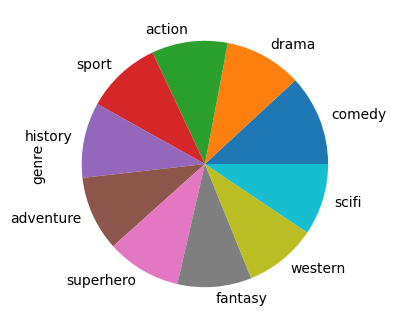

In [18]:
data[:7114].genre.value_counts().plot(kind="pie", figsize=(4,4))

In [19]:
# Is the test data balanced?
data[7114:].genre.value_counts()

comedy       349
scifi        330
western      320
superhero    303
fantasy      302
adventure    295
sport        295
history      294
action       285
drama        277
Name: genre, dtype: int64

<Axes: ylabel='genre'>

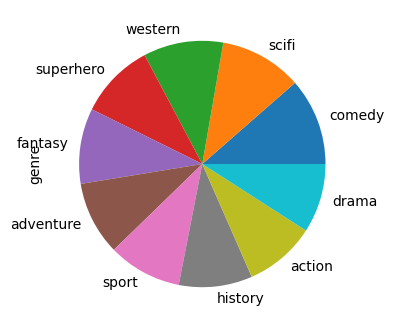

In [20]:
data[7114:].genre.value_counts().plot(kind="pie", figsize=(4,4))

## Create dataset for Training the Classifiers

In [21]:
# import the neccessary libraries
!pip install sklearn
!pip install pandas

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [22]:
import sklearn as sk
import pandas as pd
import numpy as np

In [23]:
# Create a csv list from the Training Data Set with sentiment and labels

import csv

# Example data
column1 = train_sentiment
column2 = train_labels

# Zip the two lists together to create rows
rows = zip(column1, column2)

# Specify the file name
csv_file = "movies_train.csv"

# Write data to CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Sentiment", "Labels"])  # Write header
    writer.writerows(rows)  # Write rows


In [24]:
# Create a csv list from the Test Data Set with sentiment and labels

import csv

# Example data
column1 = test_sentiment
column2 = test_labels

# Zip the two lists together to create rows
rows = zip(column1, column2)

# Specify the file name
csv_file = "movies_test.csv"

# Write data to CSV file
with open(csv_file, 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Sentiment", "Labels"])  # Write header
    writer.writerows(rows)  # Write rows


In [25]:
# Create datasets from .csv-files
import pandas as pd

movies_train = pd.read_csv('movies_train.csv', sep=',', header=0)
movies_test = pd.read_csv('movies_test.csv', sep=',', header=0)

X_tr = movies_train.iloc[:,0]
y_tr = movies_train.iloc[:,1:]

X_test = movies_test.iloc[:,0]
y_test = movies_test.iloc[:,1:]

In [26]:
movies_train

,Sentiment,Labels
0,-0.5948,8
1,0.9224,2
2,-0.0422,9
3,-0.9178,0
4,0.4276,2
...,...,...
7109,0.8674,6
7110,0.6767,2
7111,-0.4067,9
7112,0.9285,4


In [27]:
movies_test

,Sentiment,Labels
0,-0.8316,5
1,-0.3412,1
2,0.6611,1
3,0.9039,1
4,0.9418,2
...,...,...
3045,-0.8980,5
3046,0.9011,5
3047,-0.9287,5
3048,0.7149,0


# Training various classifiers

In [28]:
X_tr = X_tr.to_numpy()
y_tr = y_tr.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [39]:
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score

print("K-nearest Neighbors:")
for i in range(10):
  clf = KNeighborsRegressor(n_neighbors=i + 1)
  clf.fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))
  y_test_pred = clf.predict(X_test.reshape(-1, 1))
  y_test_pred = np.round(y_test_pred).astype(int)
  print(f"Accuracy:\t{accuracy_score(y_test, y_test_pred)}\tNeighbors:\t{i + 1}")

K-nearest Neighbors:
Accuracy:	0.10983606557377049	Neighbors:	1
Accuracy:	0.1062295081967213	Neighbors:	2
Accuracy:	0.10721311475409837	Neighbors:	3
Accuracy:	0.1019672131147541	Neighbors:	4
Accuracy:	0.1078688524590164	Neighbors:	5
Accuracy:	0.10295081967213114	Neighbors:	6
Accuracy:	0.10262295081967213	Neighbors:	7
Accuracy:	0.1062295081967213	Neighbors:	8
Accuracy:	0.09836065573770492	Neighbors:	9
Accuracy:	0.09836065573770492	Neighbors:	10


In [38]:
import pandas as pd
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

In [40]:
clf = LinearRegression()
clf.fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))
y_test_pred = clf.predict(X_test.reshape(-1, 1))
y_test_pred = np.round(y_test_pred).astype(int)
print("Linear Regression")
print(f"Accuracy:\t{accuracy_score(y_test, y_test_pred)}")

Linear Regression
Accuracy:	0.09901639344262295


In [48]:
print("Logistic Regression")
for s in ["lbfgs", "sag", "saga"]:
  LR = LogisticRegression(random_state=0, solver=s, multi_class='multinomial').fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))
  y_test_pred = LR.predict(X_test.reshape(-1, 1))
  y_test_pred = np.round(y_test_pred).astype(int)
  print(f"Accuracy:\t{accuracy_score(y_test, y_test_pred)}\tSolver:\t{s}")
print()

print("Support Vector Machine")
for df in ["ovo", "ovr"]:
  SVM = svm.SVC(decision_function_shape=df).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))
  y_test_pred = SVM.predict(X_test.reshape(-1, 1))
  y_test_pred = np.round(y_test_pred).astype(int)
  print(f"Accuracy:\t{accuracy_score(y_test, y_test_pred)}\tDecision Function:\t{df}")
print()

print("Random Forrest")
for i in range(10):
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))
  y_test_pred = RF.predict(X_test.reshape(-1, 1))
  y_test_pred = np.round(y_test_pred).astype(int)
  print(f"Accuracy:\t{accuracy_score(y_test, y_test_pred)}\tEstimators:\t{100 * (i + 1)}")
print()

NN = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))
y_test_pred = RF.predict(X_test.reshape(-1, 1))
y_test_pred = np.round(y_test_pred).astype(int)
print("Neural Network")
print(f"Accuracy:\t{accuracy_score(y_test, y_test_pred)}")

Logistic Regression
Accuracy:	0.12098360655737705	Solver:	lbfgs


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:	0.12098360655737705	Solver:	sag
Accuracy:	0.12098360655737705	Solver:	saga

Support Vector Machine


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:	0.1360655737704918	Decision Function:	ovo


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy:	0.1360655737704918	Decision Function:	ovr

Random Forrest


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12295081967213115	Estimators:	100


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12491803278688525	Estimators:	200


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12459016393442623	Estimators:	300


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12262295081967213	Estimators:	400


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12524590163934426	Estimators:	500


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12459016393442623	Estimators:	600


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12426229508196722	Estimators:	700


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12491803278688525	Estimators:	800


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12360655737704918	Estimators:	900


<ipython-input-48-c64e90dc9bad>:19: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF = RandomForestClassifier(n_estimators=100 * (i + 1), max_depth=10, random_state=0).fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))


Accuracy:	0.12491803278688525	Estimators:	1000



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1098: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Neural Network
Accuracy:	0.12491803278688525


In [49]:
# Support Vector Machine was the classifier with the highest accuracy
SVM = svm.SVC(decision_function_shape="ovo").fit(X_tr.reshape(-1, 1), y_tr.reshape(-1, 1))
y_test_pred = SVM.predict(X_test.reshape(-1, 1))
y_test_pred = np.round(y_test_pred).astype(int)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


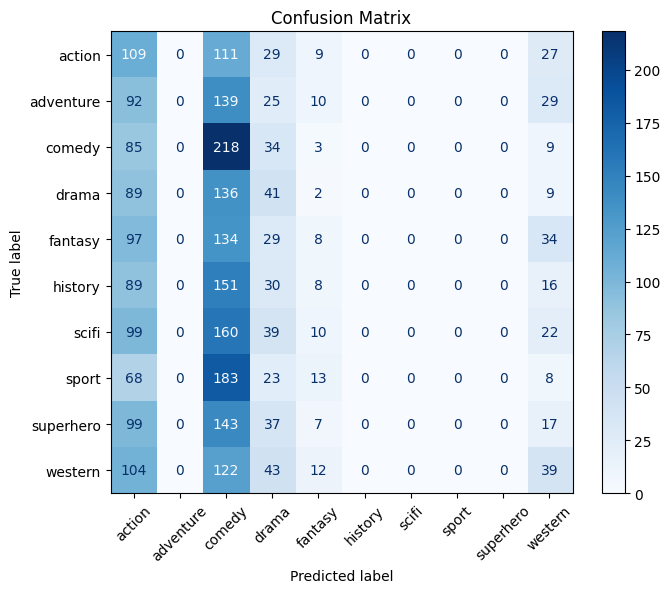

In [53]:
# creates the Confusion Matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = y_test.flatten()
y_pred = y_test_pred

fig, ax = plt.subplots(figsize=(7.5, 6))

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["action", "adventure", "comedy", "drama", "fantasy", "history", "scifi", "sport", "superhero", "western"])
disp.plot(cmap='Blues', ax=ax, xticks_rotation=45)

plt.title('Confusion Matrix')
plt.show()